In [61]:
import pandas as pds

from sklearn import linear_model
from sklearn import metrics
from sqlalchemy import create_engine

# Import Dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, MetaData, Table

# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_fscore_support


# test classification dataset
from collections import Counter
from sklearn.datasets import make_classification

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import tensorflow as tf

import numpy as np

import random

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# Create an engine for the chinook.sqlite database
# engine = create_engine("austincrime.cszdqowqamd3.us-east-1.rds.amazonaws.com", echo=False)
import psycopg2 as pg
import pandas.io.sql as psql
connection = pg.connect("host=austincrime.cszdqowqamd3.us-east-1.rds.amazonaws.com dbname=austincrime user=postgres password=T1m3T0Party")
# dataframe = psql.read_sql('SELECT * FROM product_product', connection)
# product_category = psql.read_sql_query('select * from product_category', connection)

In [3]:
# create crime_df dataframe from postgres austincrimereports_filtered table

crime_df = psql.read_sql('SELECT * FROM austincrimereports_filtered', connection)

In [4]:
# Generate our categorical variable list
crime_cat = crime_df.dtypes[crime_df.dtypes == "object"].index.tolist()

In [5]:
print(crime_cat)

['ID', 'GOHighestOffDesc', 'NIBRSUCROffDesc', 'FamilyViolence', 'OccurredDate', 'ReportDate', 'LocationType', 'Address', 'ZipCode', 'CouncilDistrict', 'APDSector', 'APDDistrict', 'PRA', 'Clearance', 'ClearanceDate', 'UCRCategory', 'CategoryDescription', 'Latitude', 'Longitude', 'Location']


In [6]:
# Check the number of unique values in each column
crime_df[crime_cat].nunique()

ID                     272901
GOHighestOffDesc           66
NIBRSUCROffDesc            58
FamilyViolence              2
OccurredDate             2684
ReportDate               2688
LocationType               45
Address                 69531
ZipCode                    54
CouncilDistrict            10
APDSector                  18
APDDistrict                17
PRA                       586
Clearance                   3
ClearanceDate            2643
UCRCategory                16
CategoryDescription         7
Latitude                65137
Longitude               65077
Location                65198
dtype: int64

In [7]:
crime_df.dtypes

ID                             object
GOHighestOffDesc               object
NIBRSUCROffDesc                object
FamilyViolence                 object
OccurredDateTime       datetime64[ns]
OccurredDate                   object
OccurredTime                  float64
ReportDateTime         datetime64[ns]
ReportDate                     object
ReportTime                      int64
LocationType                   object
Address                        object
ZipCode                        object
CouncilDistrict                object
APDSector                      object
APDDistrict                    object
PRA                            object
CensusTract                   float64
Clearance                      object
ClearanceDate                  object
UCRCategory                    object
CategoryDescription            object
XCoordinate                   float64
YCoordinate                   float64
Latitude                       object
Longitude                      object
Location    

In [8]:
# Changing Longitude and Latitude to float

crime_df["Longitude"] = crime_df.Longitude.astype(float)
crime_df["Latitude"] = crime_df.Latitude.astype(float)

In [9]:
# Dropping columns
cleaned_crime_df = crime_df.drop(['ID','GOHighestOffDesc','Location', 'ClearanceDate', 'Clearance','XCoordinate','YCoordinate','Location','Address','ReportDateTime','ReportDate','ReportTime'],axis = 1)
print(cleaned_crime_df.count())

NIBRSUCROffDesc        272901
FamilyViolence         272901
OccurredDateTime       272834
OccurredDate           272901
OccurredTime           272892
LocationType           272471
ZipCode                271995
CouncilDistrict        271120
APDSector              272306
APDDistrict            272266
PRA                    272250
CensusTract            271352
UCRCategory            272901
CategoryDescription    272901
Latitude               267241
Longitude              267241
dtype: int64


In [10]:
# Drop the null rows
cleaned_crime_df = cleaned_crime_df.dropna()
print(cleaned_crime_df.count())

NIBRSUCROffDesc        265102
FamilyViolence         265102
OccurredDateTime       265102
OccurredDate           265102
OccurredTime           265102
LocationType           265102
ZipCode                265102
CouncilDistrict        265102
APDSector              265102
APDDistrict            265102
PRA                    265102
CensusTract            265102
UCRCategory            265102
CategoryDescription    265102
Latitude               265102
Longitude              265102
dtype: int64


In [11]:
cleaned_crime_df.describe()

,OccurredTime,CensusTract,Latitude,Longitude
count,265102.000000,265102.000000,265102.000000,265102.000000
mean,1322.291974,196.663368,30.298767,-97.737164
std,688.784188,678.339344,0.079130,0.047594
min,0.000000,1.000000,30.100612,-97.929669
25%,845.000000,15.000000,30.235325,-97.764662
50%,1430.000000,24.000000,30.288806,-97.734539
75%,1900.000000,341.000000,30.360760,-97.704491
max,2359.000000,9800.000000,30.513667,-97.578053


In [12]:
# putting Latitudes and Longitudes in Bins
lat_labels = ['1','2','3','4','5','6','7','8','9','10']
cleaned_crime_df['Latitude_bin'] = pds.qcut(cleaned_crime_df['Latitude'],
                                                    q=10,labels  = lat_labels, precision = 4)
long_labels = ['1','2','3','4','5','6','7','8','9','10']
cleaned_crime_df['Longitude_bin'] = pds.qcut(cleaned_crime_df['Longitude'],
                                                    q=10,labels  = lat_labels, precision = 4)

cleaned_crime_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,PRA,CensusTract,UCRCategory,CategoryDescription,Latitude,Longitude,Latitude_bin,Longitude_bin
1,500,N,2019-04-09 12:06:00,2019-04-09,1206.0,RESIDENCE / HOME,78744,2,FR,5,493,24.11,220,Burglary,30.201607,-97.751976,2,4
2,600,N,2019-09-01 21:45:00,2019-09-01,2145.0,RESIDENCE / HOME,78702,3,CH,1,420,10.00,23H,Theft,30.252086,-97.721731,4,7
3,500,N,2019-03-13 14:43:00,2019-03-13,1443.0,RESIDENCE / HOME,78745,2,FR,3,527,24.22,220,Burglary,30.188782,-97.787951,1,2
4,609,N,2019-09-10 00:15:00,2019-09-10,15.0,RESIDENCE / HOME,78705,9,BA,1,346,5.00,23H,Theft,30.300059,-97.734236,6,6
6,600,N,2019-09-09 13:50:00,2019-09-09,1350.0,RESIDENCE / HOME,78701,9,BA,2,375,7.00,23H,Theft,30.282249,-97.746682,5,4


In [13]:
# making ZipCode an integer datatype

cleaned_crime_df['ZipCode'] = cleaned_crime_df['ZipCode'].astype(str).astype(int)
cleaned_crime_df.head(100)

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,PRA,CensusTract,UCRCategory,CategoryDescription,Latitude,Longitude,Latitude_bin,Longitude_bin
1,500,N,2019-04-09 12:06:00,2019-04-09,1206.0,RESIDENCE / HOME,78744,2,FR,5,493,24.11,220,Burglary,30.201607,-97.751976,2,4
2,600,N,2019-09-01 21:45:00,2019-09-01,2145.0,RESIDENCE / HOME,78702,3,CH,1,420,10.00,23H,Theft,30.252086,-97.721731,4,7
3,500,N,2019-03-13 14:43:00,2019-03-13,1443.0,RESIDENCE / HOME,78745,2,FR,3,527,24.22,220,Burglary,30.188782,-97.787951,1,2
4,609,N,2019-09-10 00:15:00,2019-09-10,15.0,RESIDENCE / HOME,78705,9,BA,1,346,5.00,23H,Theft,30.300059,-97.734236,6,6
6,600,N,2019-09-09 13:50:00,2019-09-09,1350.0,RESIDENCE / HOME,78701,9,BA,2,375,7.00,23H,Theft,30.282249,-97.746682,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,8503,N,2021-09-13 14:20:00,2021-09-13,1420.0,RESIDENCE / HOME,78750,6,AD,6,187,204.00,23H,Theft,30.443136,-97.787508,10,2
147,600,N,2019-09-30 19:10:00,2019-09-30,1910.0,RESTAURANTS,78754,1,ID,2,254,18.11,23H,Theft,30.330775,-97.682517,7,9
148,410,Y,2019-09-24 03:00:00,2019-09-24,300.0,RESIDENCE / HOME,78753,4,ED,3,251,18.13,13A,Aggravated Assault,30.352738,-97.691219,8,9
149,402,Y,2021-11-04 21:15:00,2021-11-04,2115.0,RESIDENCE / HOME,78758,4,ED,4,2213,419.00,13A,Aggravated Assault,30.383586,-97.696014,9,9


In [14]:
# checking number of unique values per column
cleaned_crime_df.nunique()

NIBRSUCROffDesc            44
FamilyViolence              2
OccurredDateTime       193615
OccurredDate             2628
OccurredTime             1440
LocationType               45
ZipCode                    50
CouncilDistrict            10
APDSector                  12
APDDistrict                15
PRA                       509
CensusTract               251
UCRCategory                13
CategoryDescription         6
Latitude                64293
Longitude               64235
Latitude_bin               10
Longitude_bin              10
dtype: int64

In [15]:
zipcode_counts = cleaned_crime_df.ZipCode.value_counts()
zipcode_counts

78753    21747
78741    20818
78704    19762
78758    19723
78701    14545
78723    14294
78745    14286
78744    12140
78759    11599
78702    11398
78748     8841
78752     8756
78705     8308
78757     7505
78751     6605
78746     5800
78749     5262
78731     4621
78703     4548
78727     4463
78729     4047
78754     3595
78750     3431
78724     3403
78721     3396
78756     2538
78717     2409
78735     2294
78613     2141
78722     2024
78660     1715
78617     1692
78747     1658
78726     1589
78719     1111
78739      680
78736      675
78730      654
78725      316
78742      281
78712      113
78653      107
78728       81
78652       62
78737       34
78732       25
78733        6
78610        2
78664        1
78734        1
Name: ZipCode, dtype: int64

In [16]:
# separating out month and day 
cleaned_crime_df['OccurredDate_Month'] = pds.DatetimeIndex(cleaned_crime_df['OccurredDate']).month
cleaned_crime_df['OccurredDate_Day'] = pds.DatetimeIndex(cleaned_crime_df['OccurredDate']).day
cleaned_crime_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,PRA,CensusTract,UCRCategory,CategoryDescription,Latitude,Longitude,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_Day
1,500,N,2019-04-09 12:06:00,2019-04-09,1206.0,RESIDENCE / HOME,78744,2,FR,5,493,24.11,220,Burglary,30.201607,-97.751976,2,4,4,9
2,600,N,2019-09-01 21:45:00,2019-09-01,2145.0,RESIDENCE / HOME,78702,3,CH,1,420,10.00,23H,Theft,30.252086,-97.721731,4,7,9,1
3,500,N,2019-03-13 14:43:00,2019-03-13,1443.0,RESIDENCE / HOME,78745,2,FR,3,527,24.22,220,Burglary,30.188782,-97.787951,1,2,3,13
4,609,N,2019-09-10 00:15:00,2019-09-10,15.0,RESIDENCE / HOME,78705,9,BA,1,346,5.00,23H,Theft,30.300059,-97.734236,6,6,9,10
6,600,N,2019-09-09 13:50:00,2019-09-09,1350.0,RESIDENCE / HOME,78701,9,BA,2,375,7.00,23H,Theft,30.282249,-97.746682,5,4,9,9


In [17]:
# Adding day of the week column

cleaned_crime_df['OccurredDate'] = pds.to_datetime(cleaned_crime_df['OccurredDate'])
cleaned_crime_df['OccurredDate_DayOfWeek'] = cleaned_crime_df['OccurredDate'].dt.dayofweek
cleaned_crime_df.head()


,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,CensusTract,UCRCategory,CategoryDescription,Latitude,Longitude,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek
1,500,N,2019-04-09 12:06:00,2019-04-09,1206.0,RESIDENCE / HOME,78744,2,FR,5,...,24.11,220,Burglary,30.201607,-97.751976,2,4,4,9,1
2,600,N,2019-09-01 21:45:00,2019-09-01,2145.0,RESIDENCE / HOME,78702,3,CH,1,...,10.00,23H,Theft,30.252086,-97.721731,4,7,9,1,6
3,500,N,2019-03-13 14:43:00,2019-03-13,1443.0,RESIDENCE / HOME,78745,2,FR,3,...,24.22,220,Burglary,30.188782,-97.787951,1,2,3,13,2
4,609,N,2019-09-10 00:15:00,2019-09-10,15.0,RESIDENCE / HOME,78705,9,BA,1,...,5.00,23H,Theft,30.300059,-97.734236,6,6,9,10,1
6,600,N,2019-09-09 13:50:00,2019-09-09,1350.0,RESIDENCE / HOME,78701,9,BA,2,...,7.00,23H,Theft,30.282249,-97.746682,5,4,9,9,0


In [18]:
# making OccurredTime an integer datatype

cleaned_crime_df['OccurredTime'] = cleaned_crime_df['OccurredTime'].astype(int)
cleaned_crime_df.head(100)

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,CensusTract,UCRCategory,CategoryDescription,Latitude,Longitude,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek
1,500,N,2019-04-09 12:06:00,2019-04-09,1206,RESIDENCE / HOME,78744,2,FR,5,...,24.11,220,Burglary,30.201607,-97.751976,2,4,4,9,1
2,600,N,2019-09-01 21:45:00,2019-09-01,2145,RESIDENCE / HOME,78702,3,CH,1,...,10.00,23H,Theft,30.252086,-97.721731,4,7,9,1,6
3,500,N,2019-03-13 14:43:00,2019-03-13,1443,RESIDENCE / HOME,78745,2,FR,3,...,24.22,220,Burglary,30.188782,-97.787951,1,2,3,13,2
4,609,N,2019-09-10 00:15:00,2019-09-10,15,RESIDENCE / HOME,78705,9,BA,1,...,5.00,23H,Theft,30.300059,-97.734236,6,6,9,10,1
6,600,N,2019-09-09 13:50:00,2019-09-09,1350,RESIDENCE / HOME,78701,9,BA,2,...,7.00,23H,Theft,30.282249,-97.746682,5,4,9,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,8503,N,2021-09-13 14:20:00,2021-09-13,1420,RESIDENCE / HOME,78750,6,AD,6,...,204.00,23H,Theft,30.443136,-97.787508,10,2,9,13,0
147,600,N,2019-09-30 19:10:00,2019-09-30,1910,RESTAURANTS,78754,1,ID,2,...,18.11,23H,Theft,30.330775,-97.682517,7,9,9,30,0
148,410,Y,2019-09-24 03:00:00,2019-09-24,300,RESIDENCE / HOME,78753,4,ED,3,...,18.13,13A,Aggravated Assault,30.352738,-97.691219,8,9,9,24,1
149,402,Y,2021-11-04 21:15:00,2021-11-04,2115,RESIDENCE / HOME,78758,4,ED,4,...,419.00,13A,Aggravated Assault,30.383586,-97.696014,9,9,11,4,3


In [19]:
# creating OccurredHour to help group crimes by the hour
cleaned_crime_df['OccurredHour'] = (cleaned_crime_df['OccurredTime'] / 100).apply(np.floor).astype(int) *100
cleaned_crime_df.head()


,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,UCRCategory,CategoryDescription,Latitude,Longitude,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour
1,500,N,2019-04-09 12:06:00,2019-04-09,1206,RESIDENCE / HOME,78744,2,FR,5,...,220,Burglary,30.201607,-97.751976,2,4,4,9,1,1200
2,600,N,2019-09-01 21:45:00,2019-09-01,2145,RESIDENCE / HOME,78702,3,CH,1,...,23H,Theft,30.252086,-97.721731,4,7,9,1,6,2100
3,500,N,2019-03-13 14:43:00,2019-03-13,1443,RESIDENCE / HOME,78745,2,FR,3,...,220,Burglary,30.188782,-97.787951,1,2,3,13,2,1400
4,609,N,2019-09-10 00:15:00,2019-09-10,15,RESIDENCE / HOME,78705,9,BA,1,...,23H,Theft,30.300059,-97.734236,6,6,9,10,1,0
6,600,N,2019-09-09 13:50:00,2019-09-09,1350,RESIDENCE / HOME,78701,9,BA,2,...,23H,Theft,30.282249,-97.746682,5,4,9,9,0,1300


In [20]:
# Generate our categorical variable list
crime_cat = cleaned_crime_df.dtypes[cleaned_crime_df.dtypes == "object"].index.tolist()
print(crime_cat)

['NIBRSUCROffDesc', 'FamilyViolence', 'LocationType', 'CouncilDistrict', 'APDSector', 'APDDistrict', 'PRA', 'UCRCategory', 'CategoryDescription']


In [21]:
crime_type_counts = cleaned_crime_df.CategoryDescription.value_counts()
crime_type_counts

Theft                 188733
Burglary               32649
Auto Theft             20441
Aggravated Assault     16024
Robbery                 6978
Murder                   277
Name: CategoryDescription, dtype: int64

In [22]:
# 'LocationType', 'CouncilDistrict', 'APDSector', 'APDDistrict', 'PRA', 'UCRCategory', 'CategoryDescription']
#  "FamilyViolence","OccurredTime","LocationType","ZipCode","CouncilDistrict","APDSector","Latitude_bin","Longitude_bin","OccurredDate_Month","OccurredDate_DayOfWeek","OccurredHour"

LocationType_counts = cleaned_crime_df.LocationType.value_counts()
LocationType_counts

# Determine which values to replace if counts are less than ...?
replace_locationType = list(LocationType_counts[LocationType_counts < 150].index)

# Replace in dataframe
for location in replace_locationType:
    cleaned_crime_df.LocationType = cleaned_crime_df.LocationType.replace(location,"Other")
    
# Check to make sure binning was successful
cleaned_crime_df.LocationType.value_counts()



RESIDENCE / HOME                                  91837
PARKING LOTS / GARAGE                             49659
STREETS / HWY / ROAD / ALLEY                      22522
OTHER / UNKNOWN                                   22086
DEPARTMENT / DISCOUNT STORE                       13088
COMMERCIAL / OFFICE BUILDING                      11059
GROCERY / SUPERMARKET                              9151
RESTAURANTS                                        5855
HOTEL / MOTEL / ETC.                               5614
CONVENIENCE STORE                                  5136
BAR / NIGHT CLUB                                   3715
SPECIALTY  STORE (TV  FUR ETC.)                    3443
GAS / SERVICE STATIONS                             3390
PARK / PLAYGROUND                                  2611
CONSTRUCTION SITE                                  2332
RENTAL STORAGE FACILITY                            1941
DRUG STORE / DR. OFFICE / HOSPITAL                 1802
LIQUOR STORE                                    

In [23]:
#changing FamilyViolence to 0s and 1s instead of y and n

cleaned_crime_df.FamilyViolence.replace(('Y', 'N'), (1, 0), inplace=True)
cleaned_crime_df['FamilyViolence'] = cleaned_crime_df['FamilyViolence'].astype(bool)

# changing CouncilDistrict to integer
cleaned_crime_df['CouncilDistrict'] = cleaned_crime_df['CouncilDistrict'].astype(int)


# changing PRA to integer
cleaned_crime_df['PRA'] = cleaned_crime_df['PRA'].astype(int)
cleaned_crime_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,UCRCategory,CategoryDescription,Latitude,Longitude,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour
1,500,False,2019-04-09 12:06:00,2019-04-09,1206,RESIDENCE / HOME,78744,2,FR,5,...,220,Burglary,30.201607,-97.751976,2,4,4,9,1,1200
2,600,False,2019-09-01 21:45:00,2019-09-01,2145,RESIDENCE / HOME,78702,3,CH,1,...,23H,Theft,30.252086,-97.721731,4,7,9,1,6,2100
3,500,False,2019-03-13 14:43:00,2019-03-13,1443,RESIDENCE / HOME,78745,2,FR,3,...,220,Burglary,30.188782,-97.787951,1,2,3,13,2,1400
4,609,False,2019-09-10 00:15:00,2019-09-10,15,RESIDENCE / HOME,78705,9,BA,1,...,23H,Theft,30.300059,-97.734236,6,6,9,10,1,0
6,600,False,2019-09-09 13:50:00,2019-09-09,1350,RESIDENCE / HOME,78701,9,BA,2,...,23H,Theft,30.282249,-97.746682,5,4,9,9,0,1300


In [24]:
# Generate our categorical variable list
crime_cat = cleaned_crime_df.dtypes[cleaned_crime_df.dtypes == "object"].index.tolist()
print(crime_cat)


['NIBRSUCROffDesc', 'LocationType', 'APDSector', 'APDDistrict', 'UCRCategory', 'CategoryDescription']


In [25]:
location_freq = cleaned_crime_df['LocationType'].value_counts()
# print(location_freq)
num_locations = len(location_freq)
locations = location_freq.keys()
location_dist = {}
for loc in range(num_locations):
    location_key = locations[loc]
    location_dist[location_key] = round(location_freq.values[loc] / cleaned_crime_df.shape[0], 5)
    
location_dist

{'RESIDENCE / HOME': 0.34642,
 'PARKING LOTS / GARAGE': 0.18732,
 'STREETS / HWY / ROAD / ALLEY': 0.08496,
 'OTHER / UNKNOWN': 0.08331,
 'DEPARTMENT / DISCOUNT STORE': 0.04937,
 'COMMERCIAL / OFFICE BUILDING': 0.04172,
 'GROCERY / SUPERMARKET': 0.03452,
 'RESTAURANTS': 0.02209,
 'HOTEL / MOTEL / ETC.': 0.02118,
 'CONVENIENCE STORE': 0.01937,
 'BAR / NIGHT CLUB': 0.01401,
 'SPECIALTY  STORE (TV  FUR ETC.)': 0.01299,
 'GAS / SERVICE STATIONS': 0.01279,
 'PARK / PLAYGROUND': 0.00985,
 'CONSTRUCTION SITE': 0.0088,
 'RENTAL STORAGE FACILITY': 0.00732,
 'DRUG STORE / DR. OFFICE / HOSPITAL': 0.0068,
 'LIQUOR STORE': 0.0055,
 'GOVERNMENT / PUBLIC BUILDING': 0.00442,
 'SHOPPING MALL': 0.00429,
 'TRANSPORTATION (AIR / BUS / TRAIN - TERMINALS)': 0.00406,
 'AUTO DEALERSHIP NEW / USED': 0.00394,
 'Other': 0.00255,
 'CHURCH / SYNAGOGUE / TEMPLE / MOSQUE': 0.00231,
 'BANKS / SAVINGS & LOAN': 0.00202,
 'FIELD / WOODS': 0.00193,
 'ABANDONED/CONDEMNED STRUCTURE': 0.00152,
 'COMMUNITY CENTER': 0.00098,
 

In [26]:
ranking_dict = {}

for i in range(33):
    location_key = locations[i]
    
    ranking_dict[location_key] = i + 1
    
ranking_dict

{'RESIDENCE / HOME': 1,
 'PARKING LOTS / GARAGE': 2,
 'STREETS / HWY / ROAD / ALLEY': 3,
 'OTHER / UNKNOWN': 4,
 'DEPARTMENT / DISCOUNT STORE': 5,
 'COMMERCIAL / OFFICE BUILDING': 6,
 'GROCERY / SUPERMARKET': 7,
 'RESTAURANTS': 8,
 'HOTEL / MOTEL / ETC.': 9,
 'CONVENIENCE STORE': 10,
 'BAR / NIGHT CLUB': 11,
 'SPECIALTY  STORE (TV  FUR ETC.)': 12,
 'GAS / SERVICE STATIONS': 13,
 'PARK / PLAYGROUND': 14,
 'CONSTRUCTION SITE': 15,
 'RENTAL STORAGE FACILITY': 16,
 'DRUG STORE / DR. OFFICE / HOSPITAL': 17,
 'LIQUOR STORE': 18,
 'GOVERNMENT / PUBLIC BUILDING': 19,
 'SHOPPING MALL': 20,
 'TRANSPORTATION (AIR / BUS / TRAIN - TERMINALS)': 21,
 'AUTO DEALERSHIP NEW / USED': 22,
 'Other': 23,
 'CHURCH / SYNAGOGUE / TEMPLE / MOSQUE': 24,
 'BANKS / SAVINGS & LOAN': 25,
 'FIELD / WOODS': 26,
 'ABANDONED/CONDEMNED STRUCTURE': 27,
 'COMMUNITY CENTER': 28,
 'SCHOOLS / COLLEGES': 29,
 'SCHOOL - ELEMENTARY / SECONDARY': 30,
 'SCHOOL - COLLEGE / UNIVERSITY': 31,
 'SHELTER-MISSION / HOMELESS': 32,
 'LAKE 

In [27]:
crime_cat = ['LocationType']

In [28]:
parent = cleaned_crime_df.copy()[crime_cat]
pen= cleaned_crime_df.copy()[crime_cat]
apple = cleaned_crime_df.copy()[crime_cat]
parent['ranking']=pen.replace(ranking_dict)
parent['location_dist'] = pen.replace(location_dist)

cleaned_crime_df["location_ranking"] = parent["ranking"]
cleaned_crime_df["location_dist"] = parent["location_dist"]
cleaned_crime_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,Latitude,Longitude,Latitude_bin,Longitude_bin,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour,location_ranking,location_dist
1,500,False,2019-04-09 12:06:00,2019-04-09,1206,RESIDENCE / HOME,78744,2,FR,5,...,30.201607,-97.751976,2,4,4,9,1,1200,1,0.34642
2,600,False,2019-09-01 21:45:00,2019-09-01,2145,RESIDENCE / HOME,78702,3,CH,1,...,30.252086,-97.721731,4,7,9,1,6,2100,1,0.34642
3,500,False,2019-03-13 14:43:00,2019-03-13,1443,RESIDENCE / HOME,78745,2,FR,3,...,30.188782,-97.787951,1,2,3,13,2,1400,1,0.34642
4,609,False,2019-09-10 00:15:00,2019-09-10,15,RESIDENCE / HOME,78705,9,BA,1,...,30.300059,-97.734236,6,6,9,10,1,0,1,0.34642
6,600,False,2019-09-09 13:50:00,2019-09-09,1350,RESIDENCE / HOME,78701,9,BA,2,...,30.282249,-97.746682,5,4,9,9,0,1300,1,0.34642


In [ ]:
# Create a OneHotEncoder instance
# enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
# encode_df = pds.DataFrame(enc.fit_transform(cleaned_crime_df[crime_cat]))
# Add the encoded variable names to the DataFrame
# encode_df.columns = enc.get_feature_names(crime_cat)
# encode_df.head()

In [ ]:
# Merge one-hot encoded features and drop the originals
# ml_cleaned_crime_df = cleaned_crime_df.merge(encode_df,left_index=True,right_index=True)
# ml_cleaned_crime_df = cleaned_crime_df.drop(columns=crime_cat, axis=1)
# ml_cleaned_crime_df.head()

In [33]:
# Remove CategoryDescription target from features data
y = cleaned_crime_df.CategoryDescription
# X = cleaned_crime_df[["FamilyViolence","OccurredTime","ZipCode","CouncilDistrict","PRA","Latitude_bin","Longitude_bin",
# "OccurredDate_Month","OccurredDate_DayOfWeek","OccurredHour"]]
X = cleaned_crime_df.drop(["NIBRSUCROffDesc","LocationType","OccurredDateTime","OccurredDate","APDSector","APDDistrict",
                              "UCRCategory","CategoryDescription","Latitude","Longitude","OccurredDate_Day"],axis = 1).values
# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42, stratify=y)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [34]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")


 Random forest predictive accuracy: 0.730


In [35]:
print(classification_report(y_test,y_pred))

                    precision    recall  f1-score   support

Aggravated Assault       0.79      0.51      0.62      4006
        Auto Theft       0.25      0.07      0.11      5110
          Burglary       0.47      0.22      0.30      8162
            Murder       0.17      0.01      0.03        69
           Robbery       0.22      0.05      0.08      1745
             Theft       0.76      0.93      0.84     47184

          accuracy                           0.73     66276
         macro avg       0.44      0.30      0.33     66276
      weighted avg       0.67      0.73      0.68     66276



In [36]:
precision, r, f,s = precision_recall_fscore_support(y_test,y_pred)

In [37]:
precision

array([0.78914967, 0.25201613, 0.46797652, 0.16666667, 0.22309711,
       0.76077605])

In [38]:
y.value_counts()

#random forest, logistics regression, or gradient boosted trres {sklearn and xgboost}

# sampling
    # over sampling
    # under sampling
    # data augmentation
    # from imbalanced-learn package

Theft                 188733
Burglary               32649
Auto Theft             20441
Aggravated Assault     16024
Robbery                 6978
Murder                   277
Name: CategoryDescription, dtype: int64

In [41]:
# Multinomial Logistic Regression, CensusTract
# y = cleaned_crime_df.CategoryDescription
# X = cleaned_crime_df.CensusTract
# X = cleaned_crime_df.CensusTract.values.reshape(-1, 1)

y = cleaned_crime_df.CategoryDescription
# X = cleaned_crime_df[["FamilyViolence","OccurredTime","ZipCode","CouncilDistrict","PRA","Latitude_bin","Longitude_bin","OccurredDate_Month","OccurredDate_DayOfWeek","OccurredHour"]]
X = cleaned_crime_df.drop(["NIBRSUCROffDesc","LocationType","OccurredDateTime","OccurredDate","APDSector","APDDistrict","UCRCategory","CategoryDescription","Latitude","Longitude","OccurredDate_Day"],axis = 1).values
# Split training/test datasets
X

array([[False, 1206, 78744, ..., 1200, 1, 0.34642],
       [False, 2145, 78702, ..., 2100, 1, 0.34642],
       [False, 1443, 78745, ..., 1400, 1, 0.34642],
       ...,
       [False, 1553, 78704, ..., 1500, 1, 0.34642],
       [False, 2107, 78731, ..., 2100, 3, 0.08496],
       [False, 600, 78704, ..., 600, 3, 0.08496]], dtype=object)

In [43]:
# Multinomial Logistic Regression, CensusTract
# y = cleaned_crime_df.CategoryDescription
# X = cleaned_crime_df.CensusTract
# X = cleaned_crime_df.CensusTract.values.reshape(-1, 1)

y = cleaned_crime_df.CategoryDescription
# X = cleaned_crime_df[["FamilyViolence","OccurredTime","ZipCode","CouncilDistrict","PRA","Latitude_bin","Longitude_bin","OccurredDate_Month","OccurredDate_DayOfWeek","OccurredHour"]]
X = cleaned_crime_df.drop(["NIBRSUCROffDesc","OccurredDateTime","OccurredDate",
                              "APDSector","APDDistrict","UCRCategory","CategoryDescription",
                              "Latitude","Longitude","OccurredDate_Day"],axis = 1).values
# Split training/test datasets

X



array([[False, 1206, 'RESIDENCE / HOME', ..., 1200, 1, 0.34642],
       [False, 2145, 'RESIDENCE / HOME', ..., 2100, 1, 0.34642],
       [False, 1443, 'RESIDENCE / HOME', ..., 1400, 1, 0.34642],
       ...,
       [False, 1553, 'RESIDENCE / HOME', ..., 1500, 1, 0.34642],
       [False, 2107, 'STREETS / HWY / ROAD / ALLEY', ..., 2100, 3,
        0.08496],
       [False, 600, 'STREETS / HWY / ROAD / ALLEY', ..., 600, 3, 0.08496]],
      dtype=object)

In [44]:
X.reshape(1, -1)

array([[False, 1206, 'RESIDENCE / HOME', ..., 600, 3, 0.08496]],
      dtype=object)

In [45]:
# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs',)
# fit the model on the whole dataset
model.fit(X_train_scaled, y_train)

# define a single row of input data
census_tract_list= cleaned_crime_df.CensusTract.unique().tolist()
random_census_tract= random.choice(census_tract_list)
census_tract= [random_census_tract]


C:\Users\aaron\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


For each iteration, reshape the array to (1,-1) 
then pass the reshaped array into the model

In [46]:
# predict the class label
yhat = model.predict(X_test_scaled)
yhat
# summarize the predicted class
# print('Census Tract: %s, Predicted Crime Type: %s' % (census_tract, yhat[0]))

array(['Theft', 'Theft', 'Theft', ..., 'Theft', 'Theft', 'Theft'],
      dtype=object)

In [47]:
print(classification_report(y_test, yhat))

C:\Users\aaron\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aaron\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    precision    recall  f1-score   support

Aggravated Assault       0.92      0.48      0.63      4006
        Auto Theft       0.00      0.00      0.00      5110
          Burglary       0.15      0.00      0.00      8162
            Murder       0.00      0.00      0.00        69
           Robbery       0.00      0.00      0.00      1745
             Theft       0.73      1.00      0.84     47184

          accuracy                           0.74     66276
         macro avg       0.30      0.25      0.25     66276
      weighted avg       0.60      0.74      0.64     66276



C:\Users\aaron\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


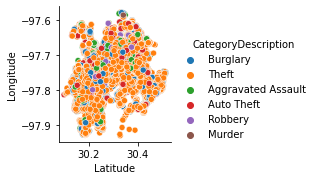

In [50]:
sns.pairplot(cleaned_crime_df,x_vars=['Latitude',],y_vars=['Longitude'],hue='CategoryDescription')

In [59]:
cenustracts = cleaned_crime_df.CensusTract.value_counts()
cenustracts

11.00     12955
21.00     10297
3.00       8473
15.00      7213
9.00       6315
          ...  
24.35         1
23.07         1
18.49         1
18.56         1
349.00        1
Name: CensusTract, Length: 251, dtype: int64